In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
#import matplotlib.cm as cm
import seaborn as sns
plt.rcParams['font.sans-serif'] = "Arial"

# Load simulation data from hard drive

Choose a parameter set and then plot the results. Note that spatial results are only set-up to work consistently for "baseline".

In [2]:
colors = plt.color_sequences['Set3']

In [3]:
parameter_set_name = 'baseline' # Options: ['baseline', 'all_dispersal', 'wrap_landscape', 'high_density', 'external_infection']
nu_vals = [120.0, 255.0, 390.0] # Duration of immunity in months

if parameter_set_name == "baseline":

    beta_vals = np.array([10.0, 30.0, 60.0, 100.0, 200.0])[::-1] #np.array([10.0, 30.0, 60.0, 100.0, 200.0, 300.0, 400.0])[::-1]
    landscape_numbers = np.arange(1, 21).astype(np.int64)
    model_names = ["model0", "model1", "model2", "model3"]#, "model3"]
    
elif parameter_set_name in ['wrap_landscape', 'all_dispersal', 'high_density']:

    if parameter_set_name == 'high_density':
        beta_vals = np.array([10.0, 20.0, 30.0, 60.0, 100.0])[::-1]
    else:
        beta_vals = np.array([10.0, 30.0, 60.0, 100.0])[::-1]
    landscape_numbers = np.arange(1, 11).astype(np.int64)
    model_names = ["model0", "model1", "model2", "model3"]

elif parameter_set_name == 'external_infection':
    
    beta_vals = np.array([1.0, 5.0, 7.5, 10.0, 30.0])[::-1]
    landscape_numbers = [1]
    model_names = ['model3']

model_results = {}
R0_vals = {}
totN_vals = []

# Loop through different models
for model_name in model_names:

    #fig, axes = plt.subplots(len(r_vals), len(nu_vals), figsize=(10, 10), sharex=True, sharey=True)
    
    all_persisting = np.empty((len(beta_vals), len(nu_vals)))
    all_duration  = np.empty((len(beta_vals), len(nu_vals)))
    
    all_persisting_var = np.empty((len(beta_vals), len(nu_vals)))
    all_duration_var  = np.empty((len(beta_vals), len(nu_vals)))

    all_seroprev_persist = np.empty((len(beta_vals), len(nu_vals)))
    all_seroprev_persist_lower = np.empty((len(beta_vals), len(nu_vals)))
    all_seroprev_persist_upper = np.empty((len(beta_vals), len(nu_vals)))
    all_seroprev = np.empty((len(beta_vals), len(nu_vals)))

    R0_vals[model_name] = np.empty((len(beta_vals), len(landscape_numbers)))
    
    for i in range(len(beta_vals)):
        for j in range(len(nu_vals)):
            
            beta = beta_vals[i]
            nu = nu_vals[j]
    
            # ax = axes[i, j]
    
            # Save quantities
            persisting = []
            duration_of_persistence = []
            seroprevalence = []
            seroprev_y1 = []
            seroprev_y2 = []
            seroprev_y3 = []
            
            # Loop through each landscape number
            for landscape_number in landscape_numbers:

                if model_name == "model3":
                    all_res = pd.read_pickle('/Volumes/MarkWilbersEH/results/stochastic_simulations/model_name={1}_beta={2}_days_in_recovery={3}_landscape{0}_{4}.pkl'.format(landscape_number, model_name, beta, nu, parameter_set_name))
                else:
                    all_res = pd.read_pickle('/Volumes/MarkWilbersEH/results/stochastic_simulations/model_name={1}_beta={2}_days_in_recovery={3}_landscape{0}_{4}.pkl'.format(landscape_number, model_name, beta, nu, parameter_set_name))
    
                # Check if length of all_res
                if len(all_res) == 2:
                    all_sims = all_res[0]
                    model_params = all_res[1]
                    if j == 0:
                        R0_vals[model_name][i, landscape_number - 1] = model_params['epi']['R0val'][0]
                else:
                    all_sims = all_res
                    
                # Loop over simulations      
                for m in range(len(all_sims)):

                    sims = all_sims[m][0][:4, :] # Just extract SEIR components
                    xvals = np.arange(sims.shape[1])
                    totN = sims.sum(axis=0)
                    if model_name == "model1":
                        totN_vals.append(totN[0])
                    #ax.plot(xvals, sims[3, :], color=colors[landscape_number - 1])
    
                    # What proportion of trajectories persist?
                    EIvals = sims[1:3, :].sum(axis=0)
                    persisting.append(EIvals[-1] > 0) # Are there any E or I vals at the end of the simulation?
    
                    # How long do trajectories persist?
                    # Note that this isn't accounting for censoring
                    dp = np.argmin(EIvals > 0)
                    if dp == 0:
                        dp = len(EIvals)
                    duration_of_persistence.append(dp)
    
                    # Extract seroprevalence through time
                    IRvals = sims[2:4, :].sum(axis=0)
                    seroprev = IRvals / totN
                    svals = [np.mean(a) for a in np.array_split(seroprev[1:], 9)] # Split the year into thirds
                    
                    persisting_ind = EIvals[-1] > 0
                    seroprevalence.append((persisting_ind, np.mean(svals[-1]))) # Seroprevalence in the last four months of year 3
                    

            #pd.DataFrame(seroprevalence).rename(columns={0:'persist', 1:'sero'}).query("persist == True").sero.mean()
            all_seroprev_persist[i, j] = pd.DataFrame(seroprevalence).rename(columns={0:'persist', 1:'sero'}).query("persist == True").sero.mean()
            all_seroprev_persist_lower[i, j] = stats.scoreatpercentile(pd.DataFrame(seroprevalence).rename(columns={0:'persist', 1:'sero'}).query("persist == True").sero.values, 0)
            all_seroprev_persist_upper[i, j] = stats.scoreatpercentile(pd.DataFrame(seroprevalence).rename(columns={0:'persist', 1:'sero'}).query("persist == True").sero.values, 100)
            all_seroprev[i, j] = pd.DataFrame(seroprevalence).rename(columns={0:'persist', 1:'sero'}).query("persist == False").sero.mean()
            all_persisting[i, j] = np.mean(persisting)
            all_duration[i, j] = np.mean(duration_of_persistence)
            all_duration_var[i, j] = np.var(duration_of_persistence)

    model_results[model_name] = (all_persisting, all_duration, all_duration_var, all_seroprev, all_seroprev_persist, all_seroprev_persist_lower, all_seroprev_persist_upper)
           
# plt.tight_layout()

# Load the spatial data for the given model

Note, only applicable when `parameter_set_name = "baseline"`

In [5]:

spatial_results = {}
median_R0_results = {}


# Loop through different models
for model_name in model_names:

    spatial_results[model_name] = []
    median_R0_results[model_name] = np.empty((len(beta_vals), len(nu_vals)))
    
    for i in range(len(beta_vals)):
        for j in range(len(nu_vals)):
            
            beta = beta_vals[i]
            nu = nu_vals[j]

            tspat_res = []
    
            # Loop through each landscape number
            mR0_over_landscape = []
            for landscape_number in landscape_numbers:
    
                all_res = pd.read_pickle('/Volumes/MarkWilbersEH/results/stochastic_simulations/model_name={1}_beta={2}_days_in_recovery={3}_landscape{0}_baseline.pkl'.format(landscape_number, model_name, beta, nu))
    
                all_sims = all_res[0]
                model_params = all_res[1]
                mR0_over_landscape.append(model_params['epi']['R0val'][0])
                    
                # Loop over simulations      
                for m in range(len(all_sims)):
        
                    spatial_res = all_sims[m][1] # Just extract SEIR components
                    tspat_res.append(spatial_res)

            median_R0_results[model_name][i, j] = np.mean(mR0_over_landscape)
            
            tdf = pd.DataFrame(tspat_res, columns=['max_dist', 'prop_groups_inf', 'percent_inf'])
            tdf = tdf.assign(beta=beta, nu=nu)
            spatial_results[model_name].append(tdf)
 
# plt.tight_layout()
full_spatial_res = pd.concat([pd.concat(spatial_results[model_name]).assign(model_name=model_name) for model_name in model_names])

## Plot the spatial spread dynamics for each model

In [6]:
full_spatial_res.loc[:, "Model name"] = full_spatial_res.model_name.replace({'model0': 'Model 1', 
                                                                             'model1': "Model 2", 
                                                                             "model2" : "Model 3", 
                                                                             "model3" : "Model 4"})
full_spatial_res = full_spatial_res.assign(max_dist_km = lambda x: x.max_dist / 1000)

In [7]:
matching_R0_vals = [1.10, 2.36, 3.58, 4.69, 6.69][::-1]
beta_R0_map = {beta : R0 for beta, R0 in zip(beta_vals, matching_R0_vals)}
R0_col = full_spatial_res.beta.map(beta_R0_map)
full_spatial_res = full_spatial_res.assign(R0 = R0_col)

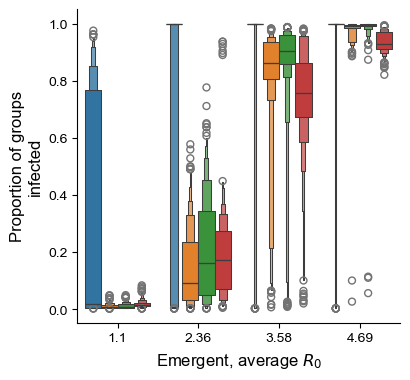

In [8]:
# Update model names
grid = sns.catplot(x="R0", y="prop_groups_inf", hue="Model name", col="nu", 
                   data=full_spatial_res.query("max_dist != 0 and nu != 255.0 and nu != 390.0 and beta != 200.0 and beta != 300.0 and beta != 400.0"), 
                   kind="boxen", height=4, legend=False)
axes = np.ravel(grid.axes)
axes[0].set_ylabel("Proportion of groups\ninfected", size=12)
axes[0].set_title("")

for ax in axes:
    ax.set_xlabel("Emergent, average $R_0$", size=12)

#grid.savefig("../results/prop_infected_spatial3.pdf", bbox_inches="tight")

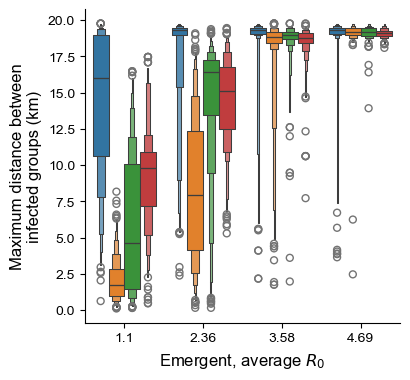

In [9]:
# Update model names
grid = sns.catplot(x="R0", y="max_dist_km", hue="Model name", col="nu", 
                   data=full_spatial_res.query("max_dist != 0 and nu != 255.0 and nu != 390.0 and beta != 200.0 and beta != 300.0 and beta != 400.0"), 
                   kind="boxen", height=4, legend=False)
axes = np.ravel(grid.axes)
axes[0].set_ylabel("Maximum distance between\ninfected groups (km)", size=12)
axes[0].set_title("")

for ax in axes:
    ax.set_xlabel("Emergent, average $R_0$", size=12)

#grid.savefig("../results/max_dist_spatial1.pdf", bbox_inches="tight")

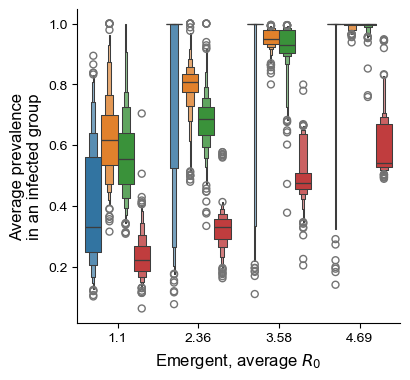

In [10]:
# Update model names
grid = sns.catplot(x="R0", y="percent_inf", hue="Model name", col="nu", 
                   data=full_spatial_res.query("max_dist != 0 and nu != 255.0 and nu != 390.0 and beta != 200.0 and beta != 300.0 and beta != 400.0"), 
                   kind="boxen", height=4, legend=False)
axes = np.ravel(grid.axes)
axes[0].set_ylabel("Average prevalence\nin an infected group", size=12)
axes[0].set_title("")

for ax in axes:
    ax.set_xlabel("Emergent, average $R_0$", size=12)

#grid.savefig("../results/avg_prev_spatial2.pdf", bbox_inches="tight")

In [11]:
beta_R0_map = {b : R for b, R in zip(beta_vals, R0_vals['model1'].mean(axis=1))}

## Plot the probability of persisting for each model

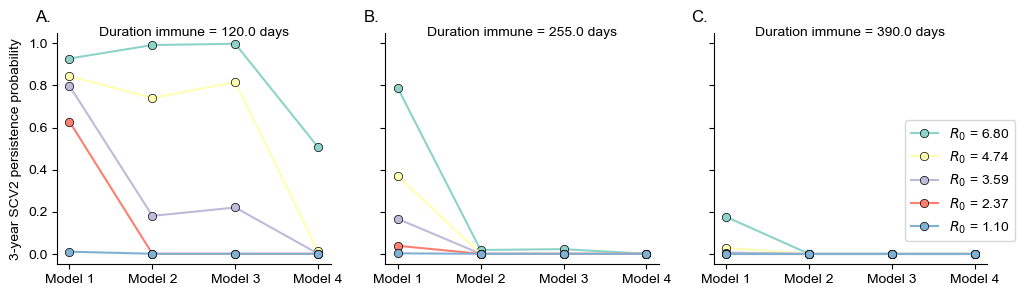

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True, sharex=True) # Stratify by duration in resistant class
axes = axes.ravel()
plot_res = []

beta_R0_map = {b : R for b, R in zip(beta_vals, R0_vals['model1'].mean(axis=1))}
    
#beta_vals = beta_vals[2:]

for m, model_name in enumerate(model_names):
    
    for beta in range(len(beta_vals)):

        for nu in range(len(nu_vals)):

            tval = model_results[model_name][0][beta, nu]
            plot_res.append((m, tval, nu_vals[nu], beta_vals[beta]))

df = pd.DataFrame(plot_res, columns=['model_num', 'persist_prob', 'nu', 'beta'])

for i in range(len(nu_vals)):
    nu = nu_vals[i]
    for j in range(len(beta_vals)):
        beta = beta_vals[j]
        
        td = df.query("nu == {0} and beta == {1}".format(nu, beta))
        axes[i].plot(td.model_num.values, td.persist_prob.values, '-o', mec='black', mew=0.5, label=r"$R_0$ = {0:.2f}".format(beta_R0_map[beta]), color=colors[j])
    axes[i].text(0.5, 0.99, "Duration immune = {0} days".format(nu), ha='center', transform=axes[i].transAxes)

letters = ["A.", "B.", "C."]
for a, ax in enumerate(axes):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_yticks(np.arange(0, 1.2, step=0.2))
    ax.text(-0.05, 1.05, letters[a], size=12, ha='center', transform=ax.transAxes)

    if a == 0:
        ax.set_ylabel("3-year SCV2 persistence probability")
        ax.set_xticks(range(4))
        ax.set_xticklabels(["Model {0}".format(i + 1) for i in range(4)])

    if a == 2:
        ax.legend(loc=(0.7, 0.1))

#fig.savefig("../results/three_year_scv2_persistence_{0}.pdf".format(parameter_set_name), bbox_inches="tight")

# Examine the seropositivity conditional on 3-year persistence and fade-out



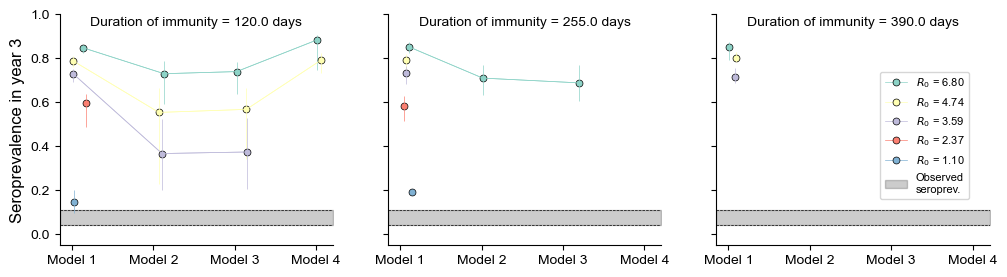

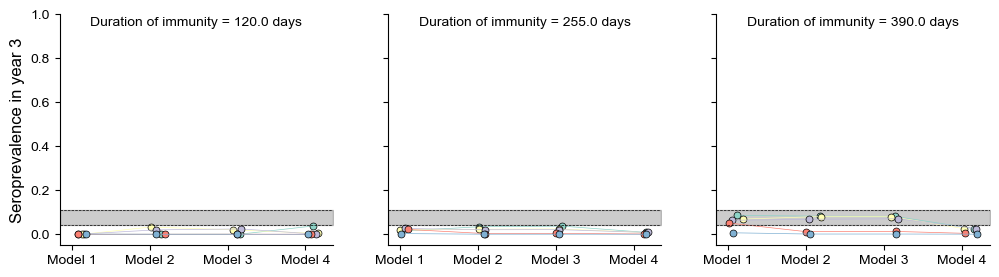

In [13]:
plot_labels = ["Seroprevalence in year 3, conditional on persistence", "Seroprevalence in year 3, all trajectories"]

# -1 is the seroprvalence in year 3 of the trajectories that persisted
# -2 is the seroprevalent in year 3 of the all simulated trajectories
for temp, k in enumerate([-3, -4]):

    fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True, sharex=True) # Stratify by duration in resistant class
    axes = axes.ravel()
    #colors = np.array(['#edf8fb','#b3cde3','#8c96c6','#88419d'])[::-1]
    plot_res = []
    for m, model_name in enumerate(model_names):
        
        for beta in range(len(beta_vals)):
    
            for nu in range(len(nu_vals)):
    
                tval = model_results[model_name][k][beta, nu]
                tval_lower = model_results[model_name][-2][beta, nu]
                tval_upper = model_results[model_name][-1][beta, nu]
                plot_res.append((m, tval, tval_lower, tval_upper, nu_vals[nu], beta_vals[beta]))
                #axes[nu].plot([m], [tval], 'o')
    
    df = pd.DataFrame(plot_res, columns=['model_num', 'persist_prob', "plower", "pupper", 'nu', 'beta'])
    
    for i in range(len(nu_vals)):
        nu = nu_vals[i]
        for j in range(len(beta_vals)):
            beta = beta_vals[j]
            
            td = df.query("nu == {0} and beta == {1}".format(nu, beta))
            rand = np.random.rand(len(td))*0.2
            axes[i].plot(td.model_num.values + rand, td.persist_prob.values, '-o', markersize=5, mec='black', mew=0.5, linewidth=0.5, label=r"$R_0$ = {0:.2f}".format(beta_R0_map[beta]), color=colors[j])

            if k == -3:
                lower = td.persist_prob.values - td.plower.values
                upper = td.pupper.values - td.persist_prob.values
                axes[i].errorbar(td.model_num.values + rand, td.persist_prob.values, yerr=[np.abs(lower), np.abs(upper)], color=colors[j], linewidth=0.5)
        axes[i].text(0.5, 0.95, "Duration of immunity = {0} days".format(nu), ha='center', transform=axes[i].transAxes)
    
    for a, ax in enumerate(axes):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
        if a == 0:
            ax.set_ylabel("Seroprevalence in year 3", size=12)
            ax.set_xticks(range(4))
            ax.set_xticklabels(["Model {0}".format(i + 1) for i in range(4)])
    
        xlim = ax.get_xlim()
        ax.hlines(0.04, *xlim, color='black', linestyle='--', linewidth=0.5)
        ax.hlines(0.11, *xlim, color='black', linestyle='--', linewidth=0.5)
        ax.fill_between(np.linspace(xlim[0], xlim[1]), 0.04, 0.11, color="black", alpha=0.2, label="Observed\nseroprev.")
        ax.set_xlim(*xlim)
        ax.set_ylim(-0.05, 1)

        if a == 2 and temp == 0:
            ax.legend(loc=(0.6, 0.2), prop={'size': 8})

    if k == -3:
        nm = "given_persistence"
    else:
        nm = "no_persistence"
    #plt.savefig("../results/seroprevalence_results_{0}_{1}.pdf".format(nm, parameter_set_name), bbox_inches="tight")

## Plot model trajectories to visualize fade-out results

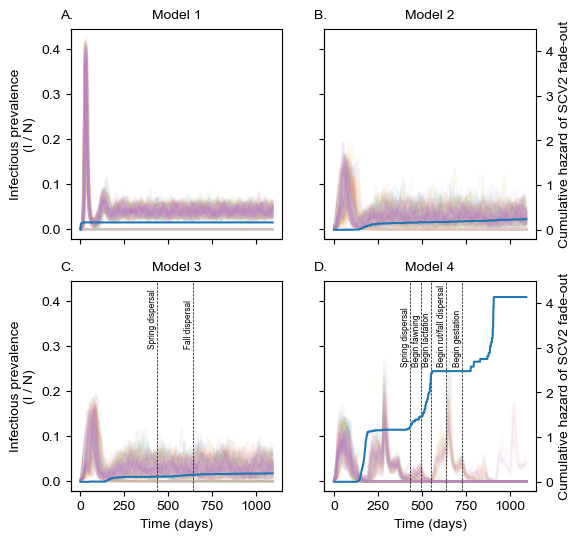

In [14]:
beta_vals = [100.0]
nu_vals = [120.0]
colors = list(plt.color_sequences['Set3'])*2
landscape_numbers = np.arange(1, 11).astype(np.int64)
model_names = ["model0", "model1", "model2", "model3"]

parameter_set_name = "baseline"

model_results = {}

letters = ["A.", "B.", "C.", "D."]
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)
axes = axes.ravel()
    
# Loop through different models
for k, model_name in enumerate(model_names):

    for i in range(len(beta_vals)):
        for j in range(len(nu_vals)):
            
            beta = beta_vals[i]
            nu = nu_vals[j]
    
            ax = axes[k]
            ax.text(0.5, 1.05, "Model {0}".format(k + 1), ha='center', transform=ax.transAxes)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            if ax.get_subplotspec().is_last_row():
                ax.set_xlabel("Time (days)")

            if ax.get_subplotspec().is_first_col():
                ax.set_ylabel("Infectious prevalence\n(I / N)")
            
            # Save quantities
            ext_curves = []
            
            # Loop through each landscape number
            for landscape_number in landscape_numbers:
    
                all_res = pd.read_pickle('/Volumes/MarkWilbersEH/results/stochastic_simulations/model_name={1}_beta={2}_days_in_recovery={3}_landscape{0}_{4}.pkl'.format(landscape_number, model_name, beta, nu, parameter_set_name))
    
                # Check if length of all_res
                if len(all_res) == 2:
                    all_sims = all_res[0]
                    model_params = all_res[1]
                else:
                    all_sims = all_res
                    
                # Loop over simulations      
                for m in range(len(all_sims)):
        
                    sims = all_sims[m][0][:4, :] # Just extract SEIR components
                    xvals = np.arange(sims.shape[1])
                    totN = sims.sum(axis=0)
                    ax.plot(xvals, sims[2, :] / totN, color=colors[landscape_number - 1], alpha=0.1)
                    sims[1:3, :].sum(axis=0) > 0
                    # Save when the pathogen fades out
                    ext_curves.append(sims[1:3, :].sum(axis=0) > 0)
                    
            extinction_probs = (1 - np.array(ext_curves).mean(axis=0))
            ax2 = ax.twinx()
            ax2.plot(xvals, -np.log(1 - extinction_probs))
    
            if ax2.get_subplotspec().is_last_col():
                ax2.set_ylabel("Cumulative hazard of SCV2 fade-out")

            if not ax2.get_subplotspec().is_last_col():
               ax2.tick_params(labelright=False, right=False)

    ax2.set_ylim(-0.2, 4.5)

    ax.text(-0.05, 1.05, letters[k], transform=ax.transAxes)
    
    # If model 3, plot the seasons for one year
    if model_name == "model3":
        seasons = np.cumsum(np.array([70, 60, 60, 85, 90])) + 365
        text_values = ["Spring dispersal", "Begin fawning", "Begin lactation", "Begin rut/fall dispersal", "Begin gestation"]
        ylim = ax.get_ylim()
        for s in range(len(seasons)):
            ax.vlines(seasons[s], *ylim, color='black', linestyle='dashed', linewidth=0.5)
            ax.text(seasons[s], 0.26, text_values[s], size=6, ha="right", rotation=90)
        ax.set_ylim(*ylim)
        # ax.set_xticks(np.arange(0, 1000, step=100))

    if model_name == "model2":
        seasons = np.cumsum(np.array([70, 205])) + 365
        ylim = ax.get_ylim()
        text_values = ["Spring dispersal", "Fall dispersal"]
        for s in range(len(seasons)):
            ax.vlines(seasons[s], *ylim, color='black', linestyle='dashed', linewidth=0.5)
            ax.text(seasons[s], 0.3, text_values[s], size=6, ha="right", rotation=90)
        ax.set_ylim(*ylim)

#fig.savefig("../results/cum_hazard_plots.pdf", bbox_inches="tight")


# Plot the external infection results for model 3

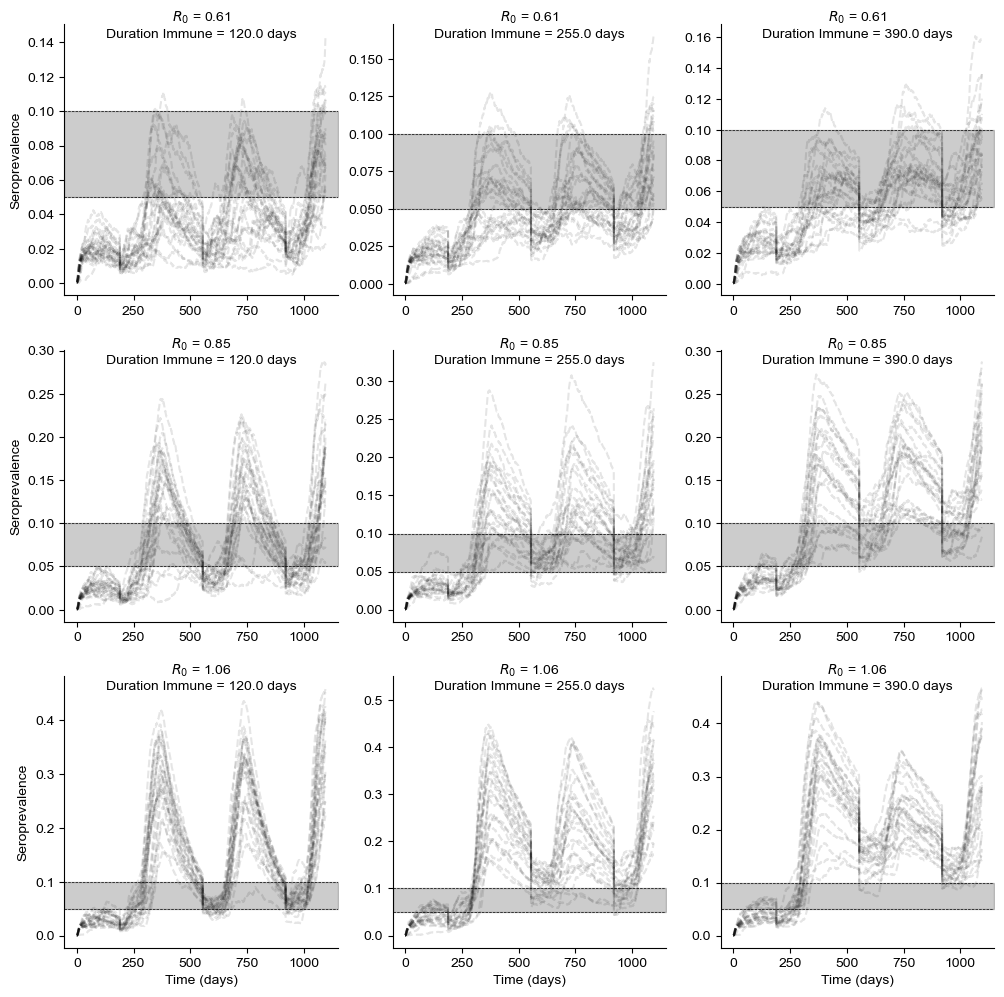

In [15]:
beta_vals = [5.0, 7.5, 10.0]
nu_vals = [120.0, 255.0, 390.0]
colors = list(plt.color_sequences['Set3'])*2
landscape_numbers = np.arange(1, 11).astype(np.int64)
model_names = ["model3"]

parameter_set_name = "external_infection"

model_results = {}

letters = ["", ""]
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=False, sharey=False)
    
# Loop through different models
for k, model_name in enumerate(model_names):

    for i in range(len(beta_vals)):
        for j in range(len(nu_vals)):
            
            beta = beta_vals[i]
            nu = nu_vals[j]
    
            ax = axes[i, j]
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            if ax.get_subplotspec().is_last_row():
                ax.set_xlabel("Time (days)")

            if ax.get_subplotspec().is_first_col():
                ax.set_ylabel("Seroprevalence")
            
            # Save quantities
            ext_curves = []
            
            # Loop through each landscape number
            for landscape_number in [1]:
    
                all_res = pd.read_pickle('/Volumes/MarkWilbersEH/results/stochastic_simulations/model_name={1}_beta={2}_days_in_recovery={3}_landscape{0}_{4}.pkl'.format(landscape_number, model_name, beta, nu, parameter_set_name))
                R0 = all_res[1]['epi']['R0val'][0]
                
                # Check if length of all_res
                if len(all_res) == 2:
                    all_sims = all_res[0]
                    model_params = all_res[1]
                else:
                    all_sims = all_res
                    
                # Loop over simulations      
                for m in range(len(all_sims)):
        
                    sims = all_sims[m][0][:4, :] # Just extract SEIR components
                    persisting = sims[1:3, -1].sum() > 0

                    if persisting:
                        xvals = np.arange(sims.shape[1])
                        totN = sims[:4, :].sum(axis=0)
                        seroprev = sims[2:4, :].sum(axis=0)
                        ax.plot(xvals, seroprev / totN, color="black", linestyle="dashed", alpha=0.1)
                        sims[1:3, :].sum(axis=0) > 0
                        # Save when the pathogen fades out
                        ext_curves.append(sims[1:3, :].sum(axis=0) > 0)
            ax.text(0.5, 0.95, "$R_0$ = {0:.2f}\nDuration Immune = {1} days".format(R0, nu), ha='center', transform=ax.transAxes)
        
            ax.text(-0.05, 1.05, letters[k], transform=ax.transAxes)
            xlim = ax.get_xlim()
            ax.hlines(0.05, *xlim, color='black', linestyle='--', linewidth=0.5)
            ax.hlines(0.1, *xlim, color='black', linestyle='--', linewidth=0.5)
            ax.fill_between(np.linspace(xlim[0], xlim[1]), 0.05, 0.1, color="black", alpha=0.2, label="Observed\nseroprev.")
            ax.set_xlim(*xlim)

    if model_name == "model2":
        seasons = np.cumsum(np.array([70, 205])) + 365
        ylim = ax.get_ylim()
        text_values = ["Spring dispersal", "Fall dispersal"]
        for s in range(len(seasons)):
            ax.vlines(seasons[s], *ylim, color='black', linestyle='dashed', linewidth=0.5)
            ax.text(seasons[s], 0.19, text_values[s], size=6, ha="right", rotation=90)
        ax.set_ylim(*ylim)

#fig.savefig("../results/external_infection_{0}.pdf".format(model_names[0]), bbox_inches="tight")